# Practical machine learning and deep learning. Lab 7

# Semantic Segmentation

# [Competition](https://www.kaggle.com/t/2e9beb0e06634b03b0e0256ea493146f)

## Goal

The goal of the lab is to implement an AE-like model for structural material semantic segmentation. To simplify the task, only concrete segmentation should be performed.

## Submission

Submission format is described at competition page.


## Semantic segmentation

Semantic segmentation is a deep learning algorithm that associates a label or category with every pixel in an image.


In [ ]:
# necessary imports
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from pathlib import Path
from torch.utils.data import random_split
import torch.nn as nn
import cv2
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
# necessary constants
CLASS_MAPPING = {
    0: "background",
    1: "steel",
    2: "concrete",  # target category - segment concrete
    3: "metal deck",
}
COLOR_MAPPING = {
    0: (0, 0, 0),
    1: (0, 0, 128),
    2: (0, 128, 0),
    3: (0, 128, 128),
}


color2label = {v: k for k, v in COLOR_MAPPING.items()}
IMG_SIZE = 256
MAX_PIXEL_VALUE = 255
NORMALIZATION_MEAN = [0.485, 0.456, 0.406]
NORMALIZATION_STD = [0.229, 0.224, 0.225]

## Dataset


In [ ]:
train_dir = "/kaggle/input/pmldl-week-7-semantic-segmentation/Dataset/train"

### Preprocessing

For the following lab we will use [Albumentations](https://albumentations.ai/) for the data transforms. Albumentations allows image and mask transformation at the same time.


In [ ]:
transforms = A.Compose(
    [
        A.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD),
        ToTensorV2()
    ]
)

### Dataset class


In [ ]:
import os
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, root_path: Path, transform):
        """
        Material segmentation dataset

        :param root_path: path to train split, which contains images and masks
        :param transform: transforms for dataset

        """
        self.transform = transform
        if not root_path.exists():
            raise FileNotFoundError(f"No root path {root_path} was found")
        self.img_path = root_path / "images"
        self.mask_path = root_path / "masks"

        if not self.img_path.exists():
            raise FileNotFoundError("No images was found")

        if not self.mask_path.exists():
            raise FileNotFoundError("No masks was found")

        # create list of images and masks
        self.img_list = self._get_filenames(self.img_path)
        self.mask_list = self._get_filenames(self.img_path)

        missing_files = set([f.stem for f in self.img_list]).symmetric_difference(
            set([f.stem for f in self.mask_list])
        )
        if len(missing_files) != 0:
            raise FileNotFoundError(f"Missing files: {missing_files}")

        # load images and masks into memory
        self._read_masks()
        self._read_imgs()
        

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]
        transformed = self.transform(image=img, mask=mask)
        return transformed["image"].float(), transformed["mask"].long()

    def __len__(self):
        return len(self.img_list)

    def _get_filenames(self, path):
        return [f for f in path.iterdir() if f.is_file()]

    def _read_imgs(self):
        """
        Load images into memory
        """
        self.images = [cv2.resize(cv2.imread(os.fspath(image)), (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR) for image in self.img_list]

    def _read_masks(self):
        """
        Load masks into memory and convert multiclass mask
        into binary masks for 'concrete' class
        """
        self.masks = [cv2.resize(cv2.imread(os.fspath(mask)), (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST) for mask in self.mask_list]
        print(cv2.inRange(self.masks[0], lowerb=COLOR_MAPPING[2], upperb=COLOR_MAPPING[2])/255)
        self.masks = [cv2.inRange(mask, lowerb=COLOR_MAPPING[2], upperb=COLOR_MAPPING[2])/255 for mask in self.masks]
        raise Exception()
        


In [ ]:
## CHECK THAT IN DATASET IT IS THE SAME
mask = '/kaggle/input/pmldl-week-7-semantic-segmentation/Dataset/train/masks/0.png'
mask = cv2.resize(cv2.imread(mask), (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
mask = cv2.inRange(mask, lowerb=COLOR_MAPPING[2], upperb=COLOR_MAPPING[2])/255
mask

In [ ]:
dataset = SegmentationDataset(Path(train_dir), transform=transforms)

# splitting dataset into train and validation
split_proportion = 0.9
size = int(len(dataset) * split_proportion)
train_dataset, val_dataset = random_split(dataset, [size, len(dataset) - size])


In [ ]:
dataset[0][1].size()

In [ ]:
# create dataloaders
batch_size = 8
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
)


In [ ]:
# check the sizes of train and validation splits
len(train_dataset), len(val_dataset)


## Model

U-Net is an architecture for semantic segmentation. It consists of a contracting path and an expansive path. The contracting path follows the typical architecture of a convolutional network. Every step in the expansive path consists of an upsampling of the feature map, a concatenation with the correspondingly cropped feature map from the contracting path, and convolutions.

### Architecture

<!-- ![Alt text](unet.png) -->
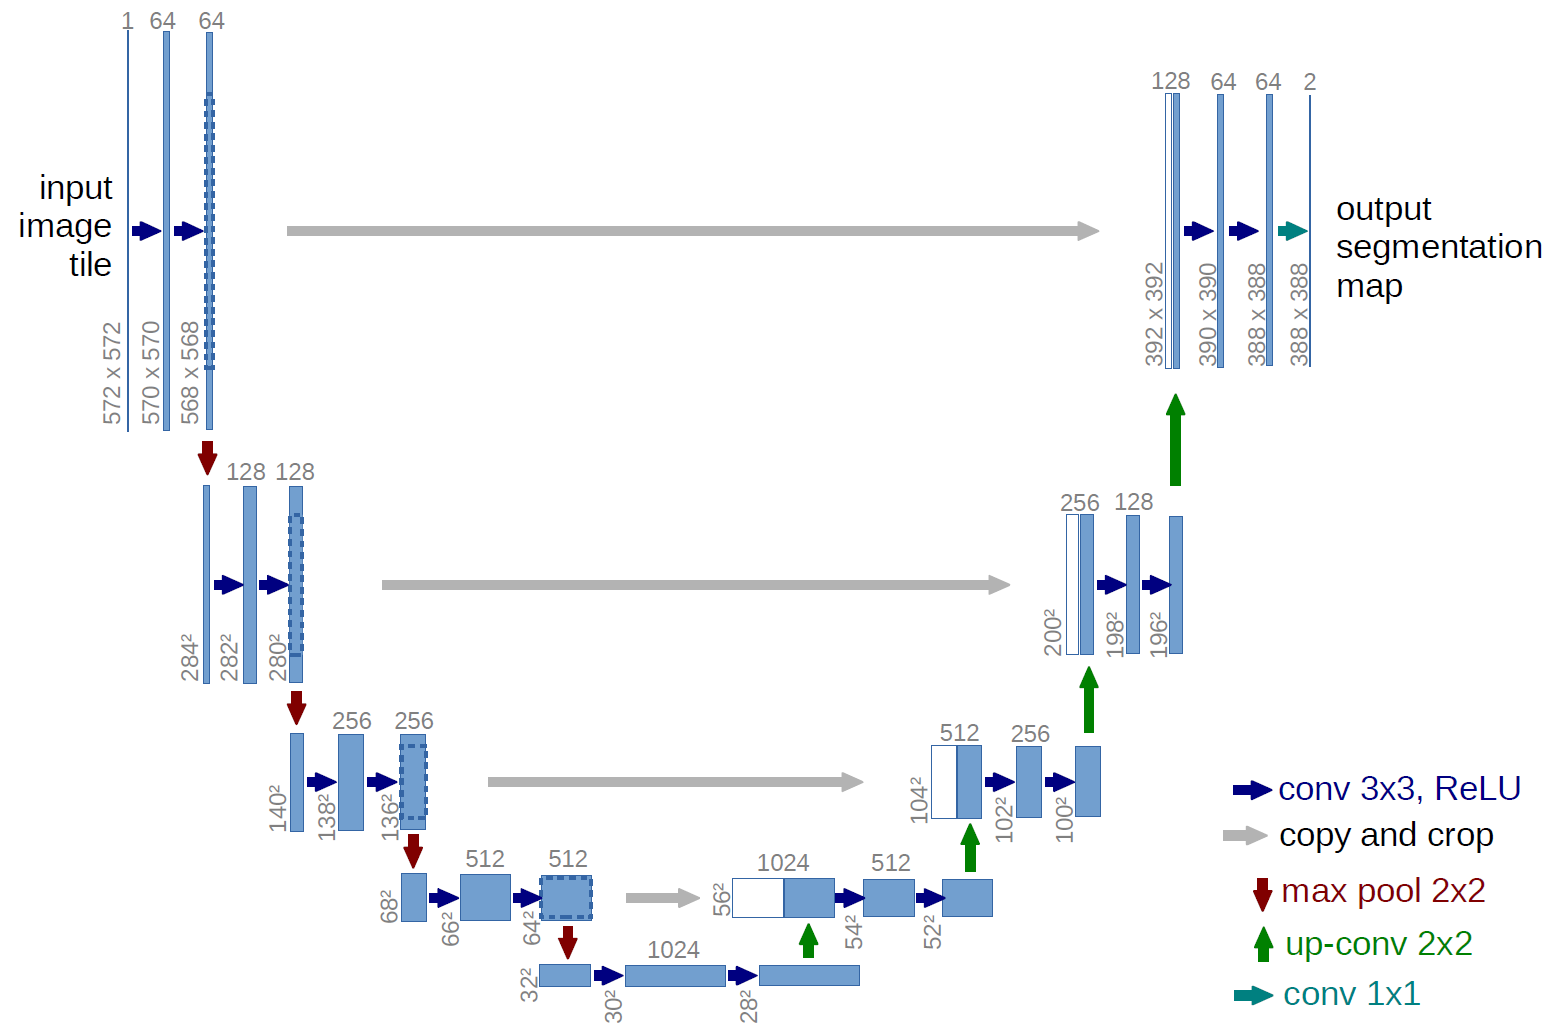

In [ ]:
class DoubleConv(nn.Module):
    """
    Block with two convolutional blocks
    """
    def __init__(self, in_channels, out_channels, mid_channels=None):
        """
        Double convolution

        :param in_channels: number of in channels for first conv layer
        :param out_channels: number of out channels for last conv layer
        :param mid_channels: number of out channels for first conv layer
        """
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels

        # write model that contains 2 conv layer with batch normalization and relu activation function
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=mid_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """
    Block for down path
    """

    def __init__(self, in_channels, out_channels):
        """
        Down block

        :param in_channels: number of in channels for double conv block
        :param out_channels: number of out channels for double conv block
        """
        super().__init__()

        # write model which contains pooling and double conv block
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """
    Block for up path
    """

    def __init__(self, in_channels, out_channels):
        """
        Down block

        :param in_channels: number of in channels for transpose convolution
        :param out_channels: number of out channels for double conv block
        """
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels=in_channels, out_channels=in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Final convolution block

        :param in_channels: number of in channels for conv layer
        :param out_channels: number of out channels for conv layer
        """
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    """
    UNet model
    """

    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
#         print(x1.size())
        x2 = self.down1(x1)
#         print(x2.size())
        x3 = self.down2(x2)
#         print(x3.size())
        x4 = self.down3(x3)
#         print(x4.size())
        x5 = self.down4(x4)
#         print(x5.size())
#         print(x5.size(), x4.size(), self.up1)
        x = self.up1(x5, x4)
#         print(x.size())
        x = self.up2(x, x3)
#         print(x.size())
        x = self.up3(x, x2)
#         print(x.size())
        x = self.up4(x, x1)
#         print(x.size())
        logits = self.outc(x)
#         print(logits.size())
        return logits

## Loss

As the loss we will use combination of Cross Entropy Loss and Dice Loss

### Dice loss

Dice loss is based on [Sørensen-Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient). It measures the overlap between the predicted and target segmentation masks. Dice loss provides a differentiable and smooth measure of segmentation accuracy.

$$
DiceLoss\left( y, \overline{p} \right) = 1 - \dfrac{\left(  2y\overline{p} + 1 \right)} {\left( y+\overline{p } + 1 \right)}
$$


In [ ]:
dataset[2][1].sum()

In [ ]:
class DiceLoss(nn.Module):
    """
    Dice loss
    """

    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, eps=1e-6):
        """
        Calculation of dice loss

        :param inputs: model predictions
        :param targets: target values
        :param eps: stability factor, defaults to 1e-6
        :return: loss value
        """
        print(inputs.size(), targets)
        dice = 1 - (2 * targets * inputs + eps) / (targets + inputs + eps)
        
        return dice


In [ ]:
model = UNet(n_channels=3, n_classes=2)

In [ ]:
optimizer = torch.optim.Adam(
    model.parameters(),
)
criterion1 = nn.CrossEntropyLoss(reduction="mean")
criterion2 = DiceLoss()


## Training


In [ ]:
def train_model(model, train_loader, val_loader, device, optimizer, epochs=1):
    model.to(device)
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(
            total=len(train_dataset), desc=f"Epoch {epoch}/{epochs}", unit="img"
        ) as pbar:
            for batch in train_loader:
                images, true_masks = batch
                images, true_masks = images.to(device), true_masks.to(device)

                masks_pred = model(images)
                loss = criterion1(masks_pred, true_masks) + criterion2(
                    masks_pred, true_masks
                )
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                pbar.update(images.shape[0])
                epoch_loss += loss.item()
                pbar.set_postfix(**{"loss (batch)": loss.item()})
        model.eval()
        with tqdm(total=len(val_dataset), desc=f"Validation", unit="img") as pbar:
            with torch.no_grad():
                for batch in val_loader:
                    images, true_masks = batch

                    images, true_masks = images.to(device), true_masks.to(device)

                    masks_pred = model(images)
                    loss = criterion1(masks_pred, true_masks) + criterion2(
                        masks_pred, true_masks
                    )
                    pbar.update(images.shape[0])
                    epoch_loss += loss.item()
                    pbar.set_postfix(**{"loss (batch)": loss.item()})


In [ ]:
train_model(model, train_loader, val_loader, "cuda", optimizer, epochs=10)


In [ ]:
torch.save(model.state_dict(), "best.pt")


## Predict


In [ ]:
import matplotlib.pyplot as plt


def plot_mask(mask, color_mapping=COLOR_MAPPING):
    color_mask = np.zeros((*mask.shape[::-1], 3), dtype=np.uint8)
    for i in range(mask.shape[1]):
        for j in range(mask.shape[0]):
            color_mask[i, j] = color_mapping[mask[j, i]]
    color_mask = cv2.cvtColor(color_mask, cv2.COLOR_BGR2RGB)
    plt.imshow(color_mask)


In [ ]:
test_transforms = A.Compose(
    [
        # your transforms here
    ]
)


In [ ]:
SUBMISSION_SHAPE = (64, 64)


def predict(model, img, device="cpu"):
    """
    Model inference on image

    :param model: model
    :param img: image
    :param device: device for computation, defaults to "cpu"
    :return: mask
    """
    model.to(device)
    model.eval()
    tensor_img = ...
    tensor_img = tensor_img.to(device=device, dtype=torch.float32).unsqueeze(0)

    with torch.no_grad():
        output = ...
        mask = ...
    mask = mask.detach().cpu().numpy()[0].astype(np.uint8)
    mask = cv2.resize(mask, SUBMISSION_SHAPE, interpolation=cv2.INTER_NEAREST)
    return mask


In [ ]:
img = cv2.imread(
    "/kaggle/input/pmldl-week-7-semantic-segmentation/Dataset/test/images/0.jpeg"
)
mask = predict(model, img)
plot_mask(mask)


## Submission


In [ ]:
def rle_encode(x, fg_val=1):
    dots = np.where(x.T.flatten() == fg_val)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    if x:  # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = "-"
    return s

In [ ]:
model = UNet(n_channels=3, n_classes=2)
model.load_state_dict(torch.load("best.pt"))


In [ ]:
import os
import pandas as pd

df = pd.DataFrame(columns=["id", "pixels"])
test_dir = "/kaggle/input/pmldl-week-7-semantic-segmentation/Dataset/test/images/"
for i, f in tqdm(enumerate(os.listdir(test_dir)), total=len(os.listdir(test_dir))):
    img = cv2.imread(test_dir + f)
    mask = predict(model, img, device="cuda")
    pred = list_to_string(rle_encode(mask))
    df.loc[i] = [f[:-5], pred]
df.to_csv("submission.csv", index=None)
